OpenGAN: Open-Set Recognition via Open Data Generation
================
**Supplemental Material for ICCV2021 Submission**


In this notebook is for demonstrating open-set semantic segmentation, especially for model selection in this task.

import packages
------------------

Some packages are installed automatically through Anaconda. PyTorch should be also installed.

In [1]:
from __future__ import print_function, division
import os, random, time, copy, scipy, pickle, sys, math, json, pickle

import argparse, pprint, shutil, logging, time, timeit
from pathlib import Path

from skimage import io, transform
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import matplotlib.pyplot as plt
# import PIL.Image
from PIL import Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

import torch, torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from collections import namedtuple

from config_HRNet import models
from config_HRNet import seg_hrnet
from config_HRNet import config
from config_HRNet import update_config
from config_HRNet.modelsummary  import *
from config_HRNet.utils import *


from utils.dataset_tinyimagenet import *
from utils.dataset_cityscapes4OpenGAN import *
from utils.eval_funcs import *


import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

# %load_ext autoreload
# %autoreload 2

3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]
1.4.0+cu92


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [2]:
# set the random seed
torch.manual_seed(10)


################## set attributes for this project/experiment ##################
# config result folder
exp_dir = './exp' # experiment directory, used for reading the init model

num_valimages = 1000
weight_adversarialLoss = 0.20
project_name = 'step030_OpenGAN_num{}_w{:.2f}'.format(num_valimages,weight_adversarialLoss)


device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:0'
    

totalEpoch = 29 # the total number of models cached (we adopt early termination)


ganBatchSize = 1000
batch_size = 1
newsize = (-1,-1)

total_epoch_num = 150 # total number of epoch in training
insertConv = False    
embDimension = 64
#isPretrained = False


# Number of channels in the training images. For color images this is 3
nc = 720
# Size of z latent vector (i.e. size of generator input)
nz = 64
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1



nClassTotal = 10
nClassCloseset = 6
runIdx = 0


save_dir = os.path.join(exp_dir, project_name)
if not os.path.exists(exp_dir): os.makedirs(exp_dir)

lr = 0.0001 # base learning rate

num_epochs = total_epoch_num
torch.cuda.device_count()
torch.cuda.empty_cache()

save_dir = os.path.join(exp_dir, project_name)
print(save_dir)    
if not os.path.exists(save_dir): os.makedirs(save_dir)

log_filename = os.path.join(save_dir, 'train.log')

./exp/step030_OpenGAN_num1000_w0.20


Define model architecture
---------

Here is the definition of the model architecture. 

In [3]:
parser = argparse.ArgumentParser(description='Train segmentation network') 
parser.add_argument('--cfg',
                    help='experiment configure file name',
                    default='./config_HRNet/seg_hrnet_w48_train_512x1024_sgd_lr1e-2_wd5e-4_bs_12_epoch484.yaml',
                    type=str)
parser.add_argument('opts',
                    help="Modify config options using the command-line",
                    default=None,
                    nargs=argparse.REMAINDER)


args = parser.parse_args(r'--cfg  ./config_HRNet/seg_hrnet_w48_train_512x1024_sgd_lr1e-2_wd5e-4_bs_12_epoch484.yaml ')
args.opts = []
update_config(config, args)






model = eval(config.MODEL.NAME + '.get_seg_model_myModel')(config)
model_dict = model.state_dict()

model_state_file = '../openset/models/hrnet_w48_cityscapes_cls19_1024x2048_ohem_trainset.pth'
pretrained_dict = torch.load(model_state_file, map_location=lambda storage, loc: storage)

suppl_dict = {}
suppl_dict['last_1_conv.weight'] = pretrained_dict['model.last_layer.0.weight'].clone()
suppl_dict['last_1_conv.bias'] = pretrained_dict['model.last_layer.0.bias'].clone()

suppl_dict['last_2_BN.running_mean'] = pretrained_dict['model.last_layer.1.running_mean'].clone()
suppl_dict['last_2_BN.running_var'] = pretrained_dict['model.last_layer.1.running_var'].clone()
# suppl_dict['last_2_BN.num_batches_tracked'] = pretrained_dict['model.last_layer.1.num_batches_tracked']
suppl_dict['last_2_BN.weight'] = pretrained_dict['model.last_layer.1.weight'].clone()
suppl_dict['last_2_BN.bias'] = pretrained_dict['model.last_layer.1.bias'].clone()

suppl_dict['last_4_conv.weight'] = pretrained_dict['model.last_layer.3.weight'].clone()
suppl_dict['last_4_conv.bias'] = pretrained_dict['model.last_layer.3.bias'].clone()


pretrained_dict = {k[6:]: v for k, v in pretrained_dict.items()
                   if k[6:] in model_dict.keys()}

model_dict.update(pretrained_dict)
model_dict.update(suppl_dict)
model.load_state_dict(model_dict)

model.eval();
model.to(device);

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)     
        

class Generator(nn.Module):
    def __init__(self, ngpu=1, nz=100, ngf=64, nc=512):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.nz = nz
        self.ngf = ngf
        self.nc = nc
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.Conv2d( self.nz, self.ngf * 8, 1, 1, 0, bias=True),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),
            # state size. (self.ngf*8) x 4 x 4
            nn.Conv2d(self.ngf * 8, self.ngf * 4, 1, 1, 0, bias=True),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),
            # state size. (self.ngf*4) x 8 x 8
            nn.Conv2d( self.ngf * 4, self.ngf * 2, 1, 1, 0, bias=True),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),
            # state size. (self.ngf*2) x 16 x 16
            nn.Conv2d( self.ngf * 2, self.ngf*4, 1, 1, 0, bias=True),
            nn.BatchNorm2d(self.ngf*4),
            nn.ReLU(True),
            # state size. (self.ngf) x 32 x 32
            nn.Conv2d( self.ngf*4, self.nc, 1, 1, 0, bias=True),
            #nn.Tanh()
            # state size. (self.nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

    
class Discriminator(nn.Module):
    def __init__(self, ngpu=1, nc=512, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.nc = nc
        self.ndf = ndf
        self.main = nn.Sequential(
            nn.Conv2d(self.nc, self.ndf*8, 1, 1, 0, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*8, self.ndf*4, 1, 1, 0, bias=True),
            nn.BatchNorm2d(self.ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*4, self.ndf*2, 1, 1, 0, bias=True),
            nn.BatchNorm2d(self.ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf*2, self.ndf, 1, 1, 0, bias=True),
            nn.BatchNorm2d(self.ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.ndf, 1, 1, 1, 0, bias=True),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [5]:
bestEpoch_GAN = 1 # random checkpoint for sanity check 

# netG = Generator(ngpu=ngpu, nz=nz, ngf=ngf, nc=nc).to(device)
netD = Discriminator(ngpu=ngpu, nc=nc, ndf=ndf).to(device)


# path_to_G = os.path.join(save_dir, 'epoch-{}.GNet'.format(bestEpoch_GAN))
path_to_D = os.path.join(save_dir, 'epoch-{}.classifier'.format(bestEpoch_GAN))
# netG.load_state_dict(torch.load(path_to_G))
netD.load_state_dict(torch.load(path_to_D, map_location=lambda storage, loc: storage))

# netG.eval()
netD.eval();

setup dataset
-----------

In [6]:
# torchvision.transforms.Normalize(mean, std, inplace=False)
imgTransformList = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

targetTransformList = transforms.Compose([
    transforms.ToTensor(),    
])


trainset = Cityscapes(root='/scratch/dataset/Cityscapes',
                             newsize=newsize, split='train', trainnum=2900, mode='fine', target_type='semantic',
                             transform=imgTransformList, target_transform=targetTransformList,
                             transforms=None)

# -10 means we fetch the last 10 images as our validation set
valset = Cityscapes(root='/scratch/dataset/Cityscapes',
                             newsize=newsize, split='train', trainnum=-10, mode='fine', target_type='semantic',
                             transform=imgTransformList, target_transform=targetTransformList,
                             transforms=None)

testset = Cityscapes(root='/scratch/dataset/Cityscapes',
                             newsize=newsize, split='val', mode='fine', target_type='semantic',
                             transform=imgTransformList, target_transform=targetTransformList,
                             transforms=None)



dataloader_test = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
dataloader_val = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4)
dataloader_train = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)


print(len(trainset), len(valset), len(testset))
classDictionary = trainset.classes

2900 10 500


In [7]:
id2trainID = {}
id2color = {}
trainID2color = {}
id2name = {}
opensetIDlist = []
for i in range(len(classDictionary)):
    id2trainID[i] = classDictionary[i][2]
    id2color[i] = classDictionary[i][-1]
    trainID2color[classDictionary[i][2]] = classDictionary[i][-1]
    id2name[i] = classDictionary[i][0]
    if classDictionary[i][-2]:
        opensetIDlist += [i]

id2trainID_list = []
for i in range(len(id2trainID)):
    id2trainID_list.append(id2trainID[i])
id2trainID_np = np.asarray(id2trainID_list)        
        
for elm in opensetIDlist:
    print(elm, id2name[elm])
print('total# {}'.format(len(opensetIDlist)))

0 unlabeled
1 ego vehicle
2 rectification border
3 out of roi
4 static
5 dynamic
6 ground
9 parking
10 rail track
14 guard rail
15 bridge
16 tunnel
18 polegroup
29 caravan
30 trailer
34 license plate
total# 16


testing a single image
-----------

In [8]:
data_sampler = iter(dataloader_train)
data = next(data_sampler)
imageList, labelList = data[0], data[1]
imageList = imageList.to(device)
labelList = labelList.to(device)

labelList = labelList.unsqueeze(1)
labelList = F.interpolate(labelList, scale_factor=0.25, mode='nearest')
labelList = labelList.squeeze()
labelList.shape

H, W = labelList.squeeze().shape
trainlabelList = id2trainID_np[labelList.cpu().numpy().reshape(-1,).astype(np.int32)]
trainlabelList = trainlabelList.reshape((1,H,W))
trainlabelList = torch.from_numpy(trainlabelList)

print(imageList.shape, labelList.shape, trainlabelList.shape)

torch.Size([1, 3, 1024, 2048]) torch.Size([256, 512]) torch.Size([1, 256, 512])


In [9]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

upsampleFunc = nn.UpsamplingBilinear2d(scale_factor=4)
with torch.no_grad():
    imageList = imageList.to(device)
    logitsTensor = model(imageList).detach().cpu()
    #logitsTensor = upsampleFunc(logitsTensor)
    softmaxTensor = F.softmax(logitsTensor, dim=1)    
    feat1Tensor = model.feat1.detach()
    feat2Tensor = model.feat2.detach()
    feat3Tensor = model.feat3.detach()
    feat4Tensor = model.feat4.detach()
    feat5Tensor = model.feat5.detach()
    torch.cuda.empty_cache()

In [10]:
allPixList = feat4Tensor.squeeze()
allPixList = allPixList.reshape(allPixList.shape[0], -1).permute(1,0).unsqueeze(-1).unsqueeze(-1).to(device)
with torch.no_grad():
    allPixConf = netD(allPixList).view(-1)
    
print(allPixConf.shape)

torch.Size([131072])


In [11]:
closesetList = trainlabelList.reshape(-1,1)
closesetList = ((closesetList>=0) & (closesetList<=18)).nonzero()
closesetList = closesetList[:,0]
#closesetList = closesetList[torch.randperm(closesetList.size()[0])]
#closesetList = closesetList[:ganBatchSize]
print(len(closesetList))

123188


In [12]:
predConfidence_closeset = torch.from_numpy(np.array([0])).type(torch.float).view(-1,1)

predConf = allPixConf[closesetList]
predConf = predConf.view(-1,1).detach()


predConfidence_closeset = torch.cat((predConfidence_closeset, predConf.detach().cpu()), 0)
print(predConf.shape)

torch.Size([123188, 1])


In [13]:
predConfidence_opensetlist = [torch.from_numpy(np.array([0])).type(torch.float).view(-1,1)]*len(opensetIDlist)

for i in range(len(opensetIDlist)):
    clsID = opensetIDlist[i]
    tmpMap = (labelList==clsID).type(torch.float32)
    tmpCount = tmpMap.sum()    
    if tmpCount==0:   
        print('not existing -- ', clsID, tmpCount)
        continue
                    
    curClsList = labelList.reshape(-1,1)
    curClsList = (curClsList==clsID).nonzero()
    curClsList = curClsList[:,0]
    
    predConf = allPixConf[curClsList]
    predConf = predConf.view(-1,1).detach()
        
    predConfidence_opensetlist[i] = torch.cat((predConfidence_opensetlist[i], predConf.detach().cpu()), 0)      
    print(clsID, id2name[clsID])
    
    
    
    
for i in range(len(opensetIDlist)):
    predConfidence_opensetlist[i] = predConfidence_opensetlist[i][1:]
    predConfidence_opensetlist[i] = predConfidence_opensetlist[i].detach().cpu().numpy()

not existing --  0 tensor(0., device='cuda:0')
1 ego vehicle
not existing --  2 tensor(0., device='cuda:0')
3 out of roi
4 static
not existing --  5 tensor(0., device='cuda:0')
6 ground
not existing --  9 tensor(0., device='cuda:0')
not existing --  10 tensor(0., device='cuda:0')
not existing --  14 tensor(0., device='cuda:0')
not existing --  15 tensor(0., device='cuda:0')
not existing --  16 tensor(0., device='cuda:0')
not existing --  18 tensor(0., device='cuda:0')
not existing --  29 tensor(0., device='cuda:0')
not existing --  30 tensor(0., device='cuda:0')
not existing --  34 tensor(0., device='cuda:0')


Text(0.5, 1.0, 'trainlabel_to_color')

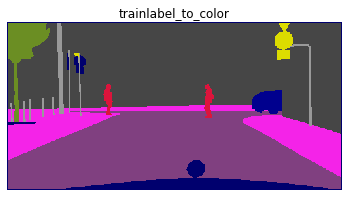

In [14]:
A = trainlabel_to_color(trainlabelList.squeeze().detach().cpu().numpy(), trainID2color)
plt.imshow(A.astype(np.uint8))
plt.axis('off')
plt.clim(0, labelList.max())
plt.title('trainlabel_to_color')    

tensor([ 1.,  3.,  4.,  6.,  7.,  8., 11., 17., 20., 21., 24., 26.],
       device='cuda:0')

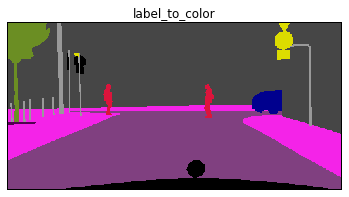

In [15]:
A = label_to_color(labelList.cpu().numpy().squeeze(), id2color)
plt.imshow(A.astype(np.uint8))
plt.axis('off')
plt.clim(0, labelList.max())
plt.title('label_to_color')    

labelList.unique()

open-set recognition
---------

GAN for open-set recognition

In [16]:
rocList = []
filename_to_save_roc = 'selectClassifier_' + project_name + '_val.pkl'
print(filename_to_save_roc)
num_valimages = 10
for bestEpoch_GAN in range(totalEpoch):  
    netD = Discriminator(ngpu=ngpu, nc=nc, ndf=ndf).to(device)
    path_to_D = os.path.join(save_dir, 'epoch-{}.classifier'.format(bestEpoch_GAN+1))
    netD.load_state_dict(torch.load(path_to_D, map_location=lambda storage, loc: storage))
    netD.eval();
    

    predConfidence_closeset = torch.from_numpy(np.array([0])).type(torch.float).view(-1,1)
    predConfidence_opensetlist = [torch.from_numpy(np.array([0])).type(torch.float).view(-1,1)]*len(opensetIDlist)
    for sample in dataloader_val:    
        if count%100==0 and count>0:
            print('{}/{}'.format(count, len(dataloader_val)))
        count += 1
        imageList, labelList = sample
        imageList = imageList.to(device)
        labelList = labelList.to(device)

        labelList = labelList.unsqueeze(1)
        labelList = F.interpolate(labelList, scale_factor=0.25, mode='nearest')
        labelList = labelList.squeeze()
        H, W = labelList.squeeze().shape
        trainlabelList = id2trainID_np[labelList.cpu().numpy().reshape(-1,).astype(np.int32)]
        trainlabelList = trainlabelList.reshape((1,H,W))
        trainlabelList = torch.from_numpy(trainlabelList)

        with torch.no_grad():
            imageList = imageList.to(device)
            logitsTensor = model(imageList).detach().cpu()
            featTensor = model.feat4.detach()

        allPixList = featTensor.squeeze()
        allPixList = allPixList.reshape(allPixList.shape[0], -1).permute(1,0).unsqueeze(-1).unsqueeze(-1).to(device)
        with torch.no_grad():
            allPixConf = netD(allPixList).view(-1)


        ################    close-set pixels    ################
        closesetList = trainlabelList.reshape(-1,1)
        closesetList = ((closesetList>=0) & (closesetList<=18)).nonzero()
        closesetList = closesetList[:,0]    
        predConf = allPixConf[closesetList]
        predConf = predConf.view(-1,1).detach()    
        predConfidence_closeset = torch.cat((predConfidence_closeset, predConf.detach().cpu()), 0)

        ################    open-set pixels    ################
        for i in range(len(opensetIDlist)):        
            clsID = opensetIDlist[i]
            tmpMap = (labelList==clsID).type(torch.float32)
            tmpCount = tmpMap.sum()    
            if tmpCount==0:   
                #print('not existing -- ', clsID, tmpCount)
                continue

            curClsList = labelList.reshape(-1,1)
            curClsList = (curClsList==clsID).nonzero()
            curClsList = curClsList[:,0]
            predConf = allPixConf[curClsList]
            predConf = predConf.view(-1,1).detach()
            predConfidence_opensetlist[i] = torch.cat((predConfidence_opensetlist[i], predConf.detach().cpu()), 0)              

    predConfidence_openset = torch.tensor([])        
    for i in range(len(opensetIDlist)):
        predConfidence_opensetlist[i] = predConfidence_opensetlist[i][1:].detach().cpu()
        if i>=3: # remove "ego vehicle", "out of roi" and "rectification border"
            predConfidence_openset = torch.cat((predConfidence_openset, predConfidence_opensetlist[i]),0)
        predConfidence_opensetlist[i] = predConfidence_opensetlist[i].numpy()
        
    predConfidence_closeset = predConfidence_closeset[1:]
    predConfidence_closeset = predConfidence_closeset.detach().cpu().numpy()
    predConfidence_openset = predConfidence_openset.numpy()
    roc_score, roc_to_plot = evaluate_openset(-predConfidence_closeset, -predConfidence_openset)
    rocList += [roc_score]
    print('{}/{} roc:{}'.format(bestEpoch_GAN, totalEpoch, roc_score))

selectClassifier_step030_OpenGAN_num1000_w0.20_val.pkl
0/29 roc:0.8045542657168512
1/29 roc:0.8934519080962876
2/29 roc:0.895303637323307
3/29 roc:0.8884856603117062
4/29 roc:0.8752582770801431
5/29 roc:0.8645951547660959
6/29 roc:0.9016062609698201
7/29 roc:0.8743030888818354
8/29 roc:0.9201573332277752
9/29 roc:0.9175803657991842
10/29 roc:0.9001231791977117
11/29 roc:0.9022931083726095
12/29 roc:0.9151644697136403
13/29 roc:0.8983293563838922
14/29 roc:0.9079718413008606
15/29 roc:0.9014192120088449
16/29 roc:0.8972301902583407
17/29 roc:0.9093332890198818
18/29 roc:0.8842788285838401
19/29 roc:0.8634011060141903
20/29 roc:0.9181098164822645
21/29 roc:0.9031136943121291
22/29 roc:0.9103406352765441
23/29 roc:0.9004244134214663
24/29 roc:0.9012821125791486
25/29 roc:0.905546044493099
26/29 roc:0.8820948616764375
27/29 roc:0.9095462020058986
28/29 roc:0.9149950117974504


In [17]:
bestROC = max(rocList)
bestModelIdx = np.argmax(np.asarray(rocList))
print(bestROC, bestModelIdx)

0.9201573332277752 8


Text(0, 0.5, 'roc on valset')

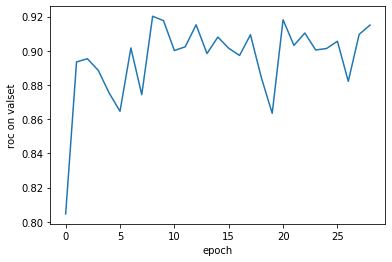

In [18]:
plt.plot(list(range(len(rocList))), rocList)
plt.xlabel('epoch')
plt.ylabel('roc on valset')

	100/500
	200/500
	300/500
	400/500
	500/500
0.9503467670459994


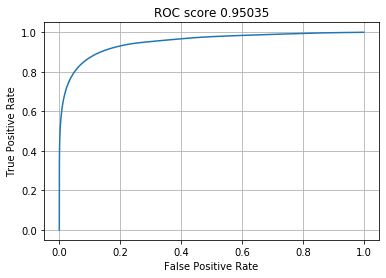

In [19]:
netD = Discriminator(ngpu=ngpu, nc=nc, ndf=ndf).to(device)
path_to_D = os.path.join(save_dir, 'epoch-{}.classifier'.format(bestModelIdx+1))
netD.load_state_dict(torch.load(path_to_D, map_location=lambda storage, loc: storage))
netD.eval();

num_valimages = 10


predConfidence_closeset = torch.from_numpy(np.array([0])).type(torch.float).view(-1,1)
predConfidence_opensetlist = [torch.from_numpy(np.array([0])).type(torch.float).view(-1,1)]*len(opensetIDlist)
count = 0
for sample in dataloader_val:   
    count += 1 
    if count<=num_valimages: 
        continue
    if count%100==0 and count>0:
        print('\t{}/{}'.format(count, len(dataloader_val)))
    imageList, labelList = sample
    imageList = imageList.to(device)
    labelList = labelList.to(device)

    labelList = labelList.unsqueeze(1)
    labelList = F.interpolate(labelList, scale_factor=0.25, mode='nearest')
    labelList = labelList.squeeze()
    H, W = labelList.squeeze().shape
    trainlabelList = id2trainID_np[labelList.cpu().numpy().reshape(-1,).astype(np.int32)]
    trainlabelList = trainlabelList.reshape((1,H,W))
    trainlabelList = torch.from_numpy(trainlabelList)

    with torch.no_grad():
        imageList = imageList.to(device)
        logitsTensor = model(imageList).detach().cpu()        
        featTensor = model.feat4.detach()


    allPixList = featTensor.squeeze()
    allPixList = allPixList.reshape(allPixList.shape[0], -1).permute(1,0).unsqueeze(-1).unsqueeze(-1).to(device)
    with torch.no_grad():
        allPixConf = netD(allPixList).view(-1)


    ################    close-set pixels    ################
    closesetList = trainlabelList.reshape(-1,1)
    closesetList = ((closesetList>=0) & (closesetList<=18)).nonzero()
    closesetList = closesetList[:,0]    
    predConf = allPixConf[closesetList]
    predConf = predConf.view(-1,1).detach()    
    predConfidence_closeset = torch.cat((predConfidence_closeset, predConf.detach().cpu()), 0)

    ################    open-set pixels    ################
    for i in range(len(opensetIDlist)):        
        clsID = opensetIDlist[i]
        tmpMap = (labelList==clsID).type(torch.float32)
        tmpCount = tmpMap.sum()    
        if tmpCount==0:   
            #print('not existing -- ', clsID, tmpCount)
            continue

        curClsList = labelList.reshape(-1,1)
        curClsList = (curClsList==clsID).nonzero()
        curClsList = curClsList[:,0]
        predConf = allPixConf[curClsList]
        predConf = predConf.view(-1,1).detach()
        predConfidence_opensetlist[i] = torch.cat((predConfidence_opensetlist[i], predConf.detach().cpu()), 0)              

for i in range(len(opensetIDlist)):
    predConfidence_opensetlist[i] = predConfidence_opensetlist[i][1:]
    predConfidence_opensetlist[i] = predConfidence_opensetlist[i].detach().cpu().numpy()                    

predConfidence_closeset = predConfidence_closeset[1:]
predConfidence_closeset = predConfidence_closeset.detach().cpu().numpy()
    
predConfidence_openset = np.concatenate(predConfidence_opensetlist, 0)
roc_score, roc_to_plot = evaluate_openset(-predConfidence_closeset, -predConfidence_openset)


plt.plot(roc_to_plot['fp'], roc_to_plot['tp'])
plt.grid('on')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score {:.5f}'.format(roc_score))
print(roc_score)

0.8756813035477743


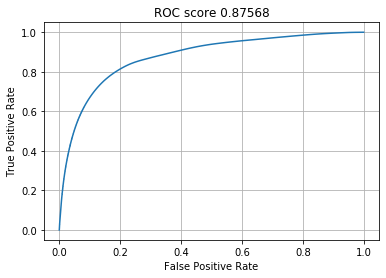

In [20]:
useless_void = ['unlabeled', 'ego vehicle', 'rectification border', 'out of roi', 'license plate']

meaningful_openset = np.asarray([0.]).reshape(1,1)
for i in range(len(predConfidence_opensetlist)):    
    clsID = opensetIDlist[i]
    
    if id2name[clsID] not in useless_void:
        meaningful_openset = np.concatenate((meaningful_openset, predConfidence_opensetlist[i]), 0)
        
        
        
roc_score, roc_to_plot = evaluate_openset(-predConfidence_closeset, -meaningful_openset)
plt.plot(roc_to_plot['fp'], roc_to_plot['tp'])
plt.grid('on')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score {:.5f}'.format(roc_score))
print(roc_score)

In [ ]:
torch.cuda.empty_cache()